## Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Initial Conditions

In [2]:
# Physical properties of the cubesat
m   = 1.33                                                      # mass of the cubesat, [kg]
s   = 0.1                                                       # length of side, [m]
I_c = m*s**2/6                                                  # moment of inertia of a cube, [kgm^2]
I = [I_c,I_c,I_c]                                               # [Ix, Iy, Iz]
Inertia =  np.diag([I_c,I_c,I_c]);                              # inertia identity matrix
# print(I_c)

# Initial conditions of angular speed and quaternions
z0  = [1,0,0,0,-0.05,0.1,0.001]                                 # array of the state vector z = [q0,q1,q2,q3,w1,w2,w3], quaternion config = scaler first then vector quantities
T   = [0,0,0]                                                   # initial condition for input torques

t_break = 100                                                  # time at which we want to break [s]
target_point1_time = 1000                                       # time at which we want to target point 1
target_point2_time = 3000                                       # time at which we want to target point 2

# Desired attitude
euler_ref1 = np.array([np.deg2rad(-10.0),np.deg2rad(-50.0),np.deg2rad(50.0)]);          #[psi, theta, phi]
euler_ref2 = np.array([np.deg2rad(0.0),np.deg2rad(0.0),np.deg2rad(0.0)]);              #[psi, theta, phi]
omega_ref = np.array([0.0,0.0,0.0]);
print(euler_ref1)

[-0.17453293 -0.87266463  0.87266463]


## Fundamental Test


In [3]:
dt= 10                                                          # change in time,  [s]
w1 = 1                                                          # initial ang vel. [rad/s]
w2 = 0                                                          # final ang vel    [rad/s]
T = I_c*(w2 - w1)/dt                                            # examplet torque  [Nm]
print(T)

tty = -(I_c*z0[5])/t_break                                      # ty               [Nm]
print(tty)

-0.00022166666666666672
-2.2166666666666673e-06


## Model


In [4]:
def skew(x):
    # quaternion representation, scalar first, q=(q0,q1,q2,q3)
    # MUST CHECK!!! now it's probvably the same as scalar last!
    
    return np.array( [ ( 0   , -x[2],  x[1]), 
                    ( x[2],  0,    -x[0]),
                    (-x[1],  x[0],  0   ) ] )
def skew4(x):
    # quaternion representation, scalar first, q=(q0,q1,q2,q3)
    # reference [1.100]
    w1 = x[0]
    w2 = x[1]
    w3 = x[2]
    
    return np.array( [  [  0,  -w1, -w2, -w3], 
                     [  w1,  0 ,  w3, -w2],
                     [  w2, -w3,  0 ,  w1],
                     [  w3,  w2, -w1,  0 ] ] )

def dcm_from_quaternion(q):
    # from book: Quaternions and Rotation Sequences pg 168
    q0,q1,q2,q3 = q #[0],q[1],q[2],q[3]    
    
    return np.array([
                [2*q0**2-1+2*q1**2, 2*(q1*q2+q0*q3),     2*(q1*q3-q0*q2)],
                [2*(q1*q2-q0*q3),   2*q0**2-1+2*q2**2,   2*(q2*q3+q0*q1)],
                [2*(q1*q3+q0*q2),   2*(q2*q3-q0*q1),     2*q0**2-1+2*q3**2]
                ])

# convert quaternions to euler angles
def euler_from_quaternion(q):
    # from book: Quaternions and Rotation Sequences pg 168
    # assumes q = [q0, q1, q2, q3] (scalar first)
    dcm = dcm_from_quaternion(q)
    
    psi   = np.arctan2(dcm[0,1],dcm[0,0])        #yaw
    theta = np.arcsin(-dcm[0,2])                 #pitch 
    phi   = np.arctan2(dcm[1,2],dcm[2,2])        #roll 
    
    return np.array([psi,theta,phi])

def controller_detumble(euler, omega, t):
    if t < t_break:
      tx = -(I_c*z0[4])/t_break                 # [Nm]
      ty = -(I_c*z0[5])/t_break                 # [Nm]
      tz = -(I_c*z0[6])/t_break                 # [Nm]      
    elif t > target_point1_time:
      
      if t > target_point2_time:
        euler_ref = euler_ref2
      else:
        euler_ref = euler_ref1

      # attitude controller
      kp = 1.0*10**-7                        # proportional gain
      kd = 2.0*10**-5                        # derivative gain

      error  = euler_ref - euler
      derror = omega_ref - omega

      tx = kp*error[2] + kd*derror[0]
      ty = kp*error[1] + kd*derror[1]
      tz = kp*error[0] + kd*derror[2]

    else:
      tx = 0
      ty = 0
      tz = 0
    
    return  torque_rod_model(tx,ty,tz)

# def attitude_controller(euler, omega, t):
#     kp = -1.0*10**-3
#     kd = 0.0

#     error  = euler_ref - euler
#     derror = omega_ref - omega

#     tx = kp*error[0] + kd*derror[0]
#     ty = kp*error[1] + kd*derror[1]
#     tz = kp*error[2] + kd*derror[2]
    
#     return torque_rod_model(tx,ty,tz)

def torque_rod_model(tx,ty,tz):
    max_torque = 6*10**-5  
     
    if tx > max_torque:                   # if control torque is greater
      tx = max_torque                     # than ability of hardware, 
    if tx < -max_torque:                  # limit torque to max_torque
      tx = -max_torque
    if ty > max_torque:
      ty = max_torque
    if ty < -max_torque:
      ty = -max_torque
    if tz > max_torque:
      tz = max_torque
    if tz < -max_torque:
      tz = -max_torque

    return np.array([tx, ty, tz])

# Function that returns dq/dt, dw1/dt, dw2/dt, dw3/dt
def model(z,t,T):
    q = z[0:4]                                           # state vector q = [q0,q1,q2,q3]
    omega = z[4:7]                                       # state vector w = [wx,wy,wz]
    
    # convert quaternion to euler
    euler = euler_from_quaternion(q)

    # compute input torques for detumbling
    Torque = controller_detumble(euler, omega, t)

    #print(t)
    # fixed last row
    
    #A = np.matrix([[0, -w1, -w2, -w3],[w1, 0, w3, -w2],[w2, -w3, 0, w1],[w3, w2, -w1, 0]])  

    domega = np.dot(np.linalg.inv(Inertia), np.dot( np.dot(-skew(omega), Inertia), omega) + Torque)
    #print(domega)
    
    # dq = 0.5*dot(skew4(omega_b_i),q)
    #q = np.matrix([[q0],[q1],[q2],[q3]])
    #dqdt = 1/2*np.dot(A,q)
    dqdt = 0.5*np.dot(skew4(omega),q)
    #print(dq)

    #dX = np.concatenate((dq,domega),1)
    #print(dX)
    
    return [dqdt[0],dqdt[1],dqdt[2],dqdt[3],domega[0], domega[1], domega[2]]

# Time points
t_end = 5000               # end time point, [s]
n = t_end + 1               # number of datapoints, including zero

time_span = np.linspace(0,t_end,n) 
#print(t)

# Solve ode
z = odeint(model,z0,time_span,args=(T,))

##Torque Array

In [5]:
Tarray = []
euler_angles = []
# T_u_max = []
for k in range(z.shape[0]):
  t = time_span[k]
  q = z[k,0:4]
  omega = z[k,4:7]
  euler = euler_from_quaternion(q)
  torque = controller_detumble(euler, omega, t)
  Tarray.append(torque)
  euler_angles.append(euler*180/np.pi)
  #print(k)
  # T_u_max.append(-max_torque)

## Plots


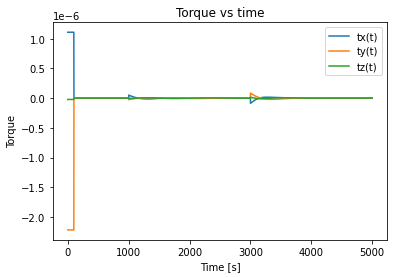

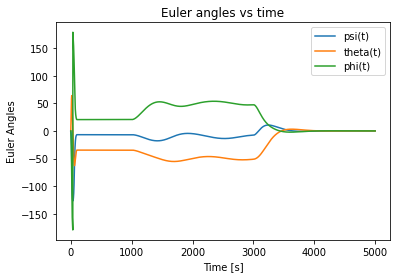

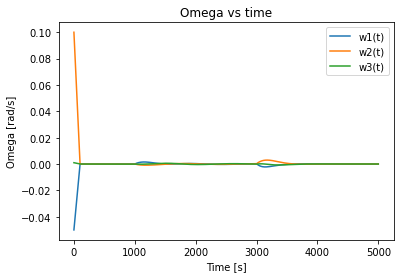

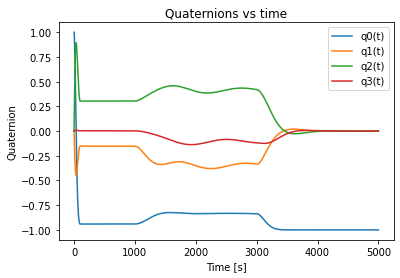

In [6]:
# Plot results
fig= plt.figure()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plt.subplot(111)
plt.plot(time_span,Tarray)
plt.xlabel('Time [s]')
plt.ylabel('Torque')
plt.legend(['tx(t)','ty(t)','tz(t)'],loc='upper right')
plt.title('Torque vs time')
plt.show()

plt.subplot(111)
plt.plot(time_span,euler_angles)
plt.xlabel('Time [s]')
plt.ylabel('Euler Angles')
plt.legend(['psi(t)','theta(t)','phi(t)'],loc='upper right')
plt.title('Euler angles vs time')
plt.show()

plt.subplot(111)
plt.plot(time_span,z[:,4:7])
plt.xlabel('Time [s]')
plt.ylabel('Omega [rad/s]')
plt.legend(['w1(t)','w2(t)','w3(t)'],loc='upper right')
plt.title('Omega vs time')
plt.show()

plt.subplot(111)
plt.plot(time_span,z[:,0:4])
plt.xlabel('Time [s]')
plt.ylabel('Quaternion')
plt.legend(['q0(t)','q1(t)','q2(t)','q3(t)'],loc='upper right')
plt.title('Quaternions vs time')
plt.show()
